In [1]:
#
# Chapter 9, Example 1b
#

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers, models
import pylab

import os
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

In [2]:
n_in = 2
n_hidden = 10
n_out = 1
n_steps = 16
n_seqs = 64

n_iters = 10000
lr = 0.001

seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.backend.set_floatx('float32')

In [3]:
# generate training data
x_train = np.random.rand(n_seqs,n_steps, n_in)
y_train = np.zeros([n_seqs,n_steps, n_out])

y_train[:,7:,0] = 5*x_train[:,6:-1, 0]*x_train[:,5:-2,1] - 2*x_train[:,:-7,0] + 3.5*x_train[:,2:-5,1]**2
y_train += 0.1*np.random.randn(n_seqs,n_steps, n_out)

x_train = tf.constant(x_train, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)

In [4]:
class SeriesPredictor(Model):

    def __init__(self, input_dim, seq_size, num_steps, hidden_dim=10, cell_type='lstm'):
        super(SeriesPredictor, self).__init__()
        # Hyperparameters
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        self.num_steps = num_steps

        # Weight variables and RNN cell
        self.W_out = tf.Variable(tf.keras.backend.random_normal([hidden_dim, 1]))
        self.b_out = tf.Variable(tf.keras.backend.random_normal([1]))
        if cell_type == 'rnn':
            cell_fn = tf.keras.layers.SimpleRNNCell
        elif cell_type == 'gru':
            cell_fn = tf.keras.layers.GRUCell
        elif cell_type == 'lstm':
            cell_fn = tf.keras.layers.LSTMCell
        self.rnn = tf.keras.layers.RNN(
            cell_fn(self.hidden_dim),
            return_sequences=True)

    def call(self, x):
        # forward logic
        outputs = self.rnn(x)
        
        out_ = []
        for i, h in enumerate(tf.split(outputs, self.num_steps, axis = 1)):
            y_ = tf.matmul(tf.squeeze(h), self.W_out) + self.b_out
            out_.append(y_)
        
        out = tf.stack(out_, axis=1)
        return out

In [5]:
# Set an optimizer and loss function for training
optimizer = tf.optimizers.Adam(lr=0.001)
def get_loss(output, target):
    mse_loss = tf.reduce_mean(tf.square(output - target))
    return mse_loss

# Training function
def train_step(model, x, target):
    with tf.GradientTape() as tape:
        out = model(x)
        mse_loss = get_loss(out, target)
        gradients = tape.gradient(mse_loss, model.variables)
        gradient_variables = zip(gradients, model.variables)
        optimizer.apply_gradients(gradient_variables)
    return mse_loss

In [6]:
def train_rnn(cell_type):
    predictor = SeriesPredictor(
        input_dim=n_in,
        seq_size=n_seqs,
        num_steps=n_steps,
        hidden_dim=n_hidden,
        cell_type=cell_type)

    loss = []
    for i in range(n_iters):
    
        l = train_step(predictor, x_train, y_train)
        loss.append(l)
    
        if not i % 100:
            print('iter:%d, cost: %g'%(i, loss[i]))
    return loss

iter:0, cost: 5.71489
iter:100, cost: 1.78111
iter:200, cost: 1.45467
iter:300, cost: 1.24508
iter:400, cost: 1.07854
iter:500, cost: 0.950938
iter:600, cost: 0.864753
iter:700, cost: 0.799378
iter:800, cost: 0.740615
iter:900, cost: 0.682694
iter:1000, cost: 0.624449
iter:1100, cost: 0.560921
iter:1200, cost: 0.494835
iter:1300, cost: 0.437691
iter:1400, cost: 0.398169
iter:1500, cost: 0.369754
iter:1600, cost: 0.345876
iter:1700, cost: 0.324712
iter:1800, cost: 0.305849
iter:1900, cost: 0.289136
iter:2000, cost: 0.274409
iter:2100, cost: 0.261493
iter:2200, cost: 0.250307
iter:2300, cost: 0.240598
iter:2400, cost: 0.232193
iter:2500, cost: 0.224924
iter:2600, cost: 0.2186
iter:2700, cost: 0.213059
iter:2800, cost: 0.208208
iter:2900, cost: 0.204836
iter:3000, cost: 0.200039
iter:3100, cost: 0.196563
iter:3200, cost: 0.193302
iter:3300, cost: 0.190289
iter:3400, cost: 0.187392
iter:3500, cost: 0.184615
iter:3600, cost: 0.18185
iter:3700, cost: 0.179099
iter:3800, cost: 0.17628
iter:39

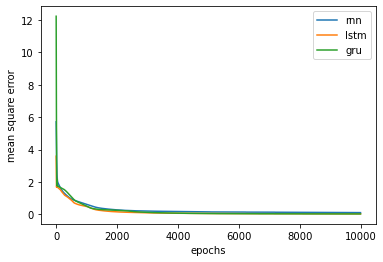

In [7]:
pylab.figure()
loss = train_rnn('rnn')
pylab.plot(range(n_iters), loss, label='rnn')

loss = train_rnn('lstm')
pylab.plot(range(n_iters), loss, label='lstm')

loss = train_rnn('gru')
pylab.plot(range(n_iters), loss, label='gru')

pylab.xlabel('epochs')
pylab.ylabel('mean square error')
pylab.legend()

pylab.savefig('./figures/9.1b_1.png')


pylab.show()
